In [133]:
library(ggplot2)
library(ggmap)
library(dplyr)
library(data.table)
library(ggthemes)
source('../code/Function.R')
source('../code/FunctionForRealShip.R')

In [134]:
#read table, sog must *10
points = fread('D:/Git/Rprojects/basedata/points_413623000.csv',sep=',',header = TRUE)
auxPowerdt = fread('D:/Git/Rprojects/basedata/auxLoadKW.csv',sep=',',header = TRUE)
eFactordt = fread('D:/Git/Rprojects/basedata/EmissionFactors.txt',sep=' ',header = TRUE)
fcFactordt = fread('D:/Git/Rprojects/basedata/FuelCorrectionFactors.csv',sep=',',header = TRUE)
#low load adjustment multipler
llaFactordt = fread('D:/Git/Rprojects/basedata/LowLoadAdjustmentFactors.csv',sep=',',header = TRUE)
#set column name
points=points[,list(longitude,latitude,timestamp,shipSpeed)]
points=points[,shipSpeed:=shipSpeed*10]#change the unit of speed to 0.1 knot
setnames(points,c('lon','lat','time','sog'))

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35.155039,120.905224&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


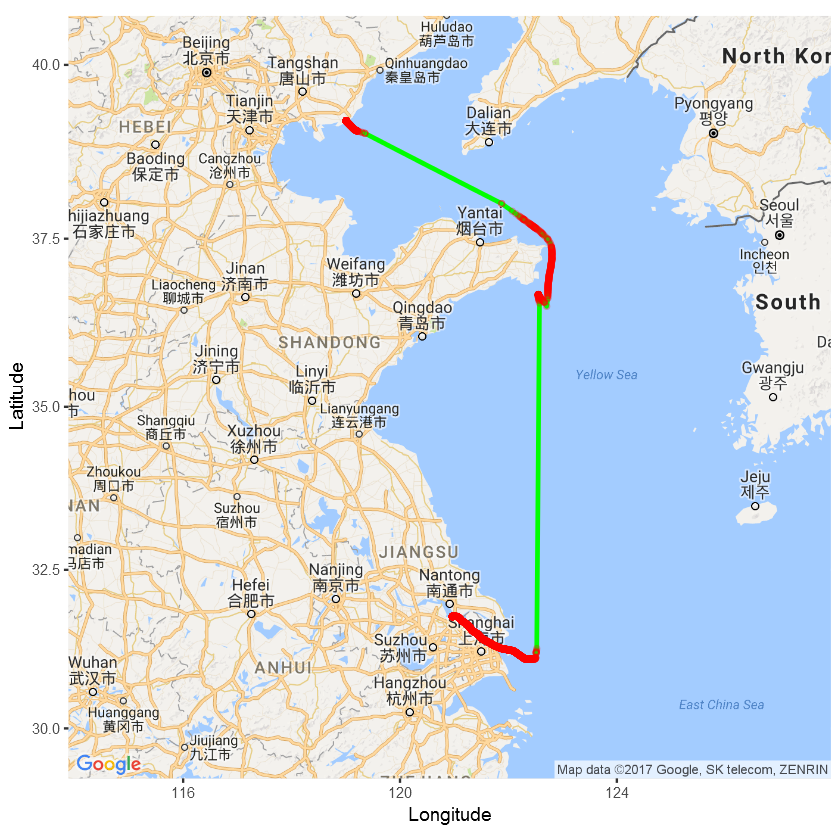

In [135]:
temp=points
zoomSize=6
centerX=0.5*(max(temp$lon)+min(temp$lon))
centerY=0.5*(max(temp$lat)+min(temp$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=zoomSize,source='google',maptype = 'roadmap'))
p=p+geom_path(data=temp,aes(x=lon,y=lat),color='green',size=1)
p=p+geom_point(data=temp,aes(x=lon,y=lat),shape=21,color='red',size=1,alpha=0.3)
p=p+scale_color_brewer(name='标记',labels=c("轨迹点","连线"))
p=p+labs(x="Longitude",y="Latitude")
p

In [140]:
scale=4 # grid size 
points=setPoints(points,scale)
lines=setLines(points)
lines=addLineSpeed(lines,600,2) # average speed = (s1+s2)/2 if timespan <600s or distance <2 nm
dt=lines[,list(lid,timespan,avgspeed)]

In [141]:
#----------------------
mmsi=413623000
power=4400
MCR=power
sSpeed=12 # 采用服务航速代替设计航速，以考虑主机de-rating 
DWT=22659
mBaseEF=eFactordt[Engine=='Main'&Sulfur=='2.7'&EngineType=='MSD'&IMOTier=='Tier1',8:length(eFactordt),with=FALSE]
auxEF=eFactordt[Engine=='Aux'&Sulfur=='0.5'&EngineType=='MSD'&IMOTier=='Tier1',8:length(eFactordt),with=FALSE]
BoilerEF=eFactordt[Engine=='Boiler'&Sulfur=='0.5'&EngineType=='Steamship',8:length(eFactordt),with=FALSE]
cargoLoad=1 # the ship is loaded
weatherFactor=1 # shiping near shore 1.1, or 1.15 if shipping in ocean
hullFactor=1 # resistance caused by hull roughness, more than four years 0.09
dt=dt[,load.main:=getMainLoad(avgspeed,sSpeed*10)*cargoLoad^(2/3)*weatherFactor*hullFactor]

In [142]:
#set ship status: 1 for berth,2for anchor,3for maneuvering,4for lowCruise,5for highCruise
dt=dt[,model:=0]
dt=dt[avgspeed<1,model:=1]
dt=dt[avgspeed>=1&avgspeed<3,model:=2]
dt=dt[avgspeed>=3&load.main<0.2,model:=3]
dt=dt[load.main>=0.2&load.main<0.65,model:=4]
dt=dt[load.main>=0.65,model:=5]
# main engine load is not less than 0.02 under maneuvering status
dt=dt[load.main<0.02&model==3,load.main:=0.02]

dt=dt[,loadId:=100*round(load.main,2)] # to join with low load factor table
dt=dt[load.main>19.5||load.main<1.5,loadId:=20]#only load with in (0.02,0.2) need adject

#----------------calculate emission factors------------------
llaFactordt=llaFactordt[,loadId:=Load]
setkey(llaFactordt,loadId)
setkey(dt,loadId)
dt=data.table(left_join(dt,llaFactordt,by='loadId'))
setnames(dt,c('loadId','lid', 'timespan','avgspeed','load.main','model','Load','llaPM2.5','llaPM10','llaDPM','llaNOx','llaSOx','llaCO','llaHC','llaCO2','llaN2O','llaCH4'))

In [143]:
#main engine emission:kw*n*g/kwh*n*s/3600/1000/1000: tons
dt=dt[,mePM2.5:=MCR*load.main*mBaseEF$PM2.5*llaPM2.5*timespan/3600/1000/1000]
dt=dt[,mePM10:=MCR*load.main*mBaseEF$PM10*llaPM10*timespan/3600/1000/1000]
dt=dt[,meDPM:=MCR*load.main*mBaseEF$DPM*llaDPM*timespan/3600/1000/1000]
dt=dt[,meNOx:=MCR*load.main*mBaseEF$NOx*llaNOx*timespan/3600/1000/1000]
dt=dt[,meSOx:=MCR*load.main*mBaseEF$SOx*llaSOx*timespan/3600/1000/1000]
dt=dt[,meCO:=MCR*load.main*mBaseEF$CO*llaCO*timespan/3600/1000/1000]
dt=dt[,meHC:=MCR*load.main*mBaseEF$HC*llaHC*timespan/3600/1000/1000]
dt=dt[,meCO2:=MCR*load.main*mBaseEF$CO2*llaCO2*timespan/3600/1000/1000]
dt=dt[,meN2O:=MCR*load.main*mBaseEF$N2O*llaN2O*timespan/3600/1000/1000]
dt=dt[,meCH4:=MCR*load.main*mBaseEF$CH4*llaCH4*timespan/3600/1000/1000]
# co2 to oil, 3.18 from (losengle port,2009), 
#sum(dt$mePM2.5) sum(dt$mePM10) sum(dt$meDPM) sum(dt$meNOx) sum(dt$meSOx) sum(dt$meCO) sum(dt$meHC) sum(dt$meCO2) sum(dt$meN2O) sum(dt$meCH4)
main.CO2=sum(dt$meCO2)
main.fuel=main.CO2/3.18
(sum(dt$meCO2)/3.18-38.1)/38.1

[1] -0.07059851

In [148]:
#------------aux engine-----------seems from imo 2014
auxPower=auxPowerdt[ShipClass=='General cargo'&CapacityFrom<DWT&CapacityTo>DWT,5:8,with=FALSE]
dt=dt[,aePM2.5:=0]
dt=dt[,aePM10:=0]
dt=dt[,aeDPM:=0]
dt=dt[,aeNOx:=0]
dt=dt[,aeSOx:=0]
dt=dt[,aeCO:=0]
dt=dt[,aeHC:=0]
dt=dt[,aeCO2:=0]
dt=dt[,aeN2O:=0]
dt=dt[,aeCH4:=0]
auxPower

Berth Anchorage Maneuvering Sea
1 970   490       730         490

In [156]:
#-------------------Port 2009 ---------------
#aux load = MRC*powerRatio*loadfactor
auxPower$Berth=252
auxPower$Anchorage=252
auxPower$Maneuvering=420
auxPower$SRZ=205
auxPower$Sea=159

In [157]:
dt=dt[model==1,aePM2.5:=auxPower$Berth*auxEF$PM2.5*timespan/3600/1000/1000]
dt=dt[model==1,aePM10:=auxPower$Berth*auxEF$PM10*timespan/3600/1000/1000]
dt=dt[model==1,aeDPM:=auxPower$Berth*auxEF$DPM*timespan/3600/1000/1000]
dt=dt[model==1,aeNOx:=auxPower$Berth*auxEF$NOx*timespan/3600/1000/1000]
dt=dt[model==1,aeSOx:=auxPower$Berth*auxEF$SOx*timespan/3600/1000/1000]
dt=dt[model==1,aeCO:=auxPower$Berth*auxEF$CO*timespan/3600/1000/1000]
dt=dt[model==1,aeHC:=auxPower$Berth*auxEF$HC*timespan/3600/1000/1000]
dt=dt[model==1,aeCO2:=auxPower$Berth*auxEF$CO2*timespan/3600/1000/1000]
dt=dt[model==1,aeN2O:=auxPower$Berth*auxEF$N2O*timespan/3600/1000/1000]
dt=dt[model==1,aeCH4:=auxPower$Berth*auxEF$CH4*timespan/3600/1000/1000]

dt=dt[model==2,aePM2.5:=auxPower$Anchorage*auxEF$PM2.5*timespan/3600/1000/1000]
dt=dt[model==2,aePM10:=auxPower$Anchorage*auxEF$PM10*timespan/3600/1000/1000]
dt=dt[model==2,aeDPM:=auxPower$Anchorage*auxEF$DPM*timespan/3600/1000/1000]
dt=dt[model==2,aeNOx:=auxPower$Anchorage*auxEF$NOx*timespan/3600/1000/1000]
dt=dt[model==2,aeSOx:=auxPower$Anchorage*auxEF$SOx*timespan/3600/1000/1000]
dt=dt[model==2,aeCO:=auxPower$Anchorage*auxEF$CO*timespan/3600/1000/1000]
dt=dt[model==2,aeHC:=auxPower$Anchorage*auxEF$HC*timespan/3600/1000/1000]
dt=dt[model==2,aeCO2:=auxPower$Anchorage*auxEF$CO2*timespan/3600/1000/1000]
dt=dt[model==2,aeN2O:=auxPower$Anchorage*auxEF$N2O*timespan/3600/1000/1000]
dt=dt[model==2,aeCH4:=auxPower$Anchorage*auxEF$CH4*timespan/3600/1000/1000]

dt=dt[model==3,aePM2.5:=auxPower$Maneuvering*auxEF$PM2.5*timespan/3600/1000/1000]
dt=dt[model==3,aePM10:=auxPower$Maneuvering*auxEF$PM10*timespan/3600/1000/1000]
dt=dt[model==3,aeDPM:=auxPower$Maneuvering*auxEF$DPM*timespan/3600/1000/1000]
dt=dt[model==3,aeNOx:=auxPower$Maneuvering*auxEF$NOx*timespan/3600/1000/1000]
dt=dt[model==3,aeSOx:=auxPower$Maneuvering*auxEF$SOx*timespan/3600/1000/1000]
dt=dt[model==3,aeCO:=auxPower$Maneuvering*auxEF$CO*timespan/3600/1000/1000]
dt=dt[model==3,aeHC:=auxPower$Maneuvering*auxEF$HC*timespan/3600/1000/1000]
dt=dt[model==3,aeCO2:=auxPower$Maneuvering*auxEF$CO2*timespan/3600/1000/1000]
dt=dt[model==3,aeN2O:=auxPower$Maneuvering*auxEF$N2O*timespan/3600/1000/1000]
dt=dt[model==3,aeCH4:=auxPower$Maneuvering*auxEF$CH4*timespan/3600/1000/1000]

dt=dt[model==5,aePM2.5:=auxPower$Sea*auxEF$PM2.5*timespan/3600/1000/1000]
dt=dt[model==5,aePM10:=auxPower$Sea*auxEF$PM10*timespan/3600/1000/1000]
dt=dt[model==5,aeDPM:=auxPower$Sea*auxEF$DPM*timespan/3600/1000/1000]
dt=dt[model==5,aeNOx:=auxPower$Sea*auxEF$NOx*timespan/3600/1000/1000]
dt=dt[model==5,aeSOx:=auxPower$Sea*auxEF$SOx*timespan/3600/1000/1000]
dt=dt[model==5,aeCO:=auxPower$Sea*auxEF$CO*timespan/3600/1000/1000]
dt=dt[model==5,aeHC:=auxPower$Sea*auxEF$HC*timespan/3600/1000/1000]
dt=dt[model==5,aeCO2:=auxPower$Sea*auxEF$CO2*timespan/3600/1000/1000]
dt=dt[model==5,aeN2O:=auxPower$Sea*auxEF$N2O*timespan/3600/1000/1000]
dt=dt[model==5,aeCH4:=auxPower$Sea*auxEF$CH4*timespan/3600/1000/1000]

dt=dt[model==4,aePM2.5:=auxPower$SRZ*auxEF$PM2.5*timespan/3600/1000/1000]
dt=dt[model==4,aePM10:=auxPower$SRZ*auxEF$PM10*timespan/3600/1000/1000]
dt=dt[model==4,aeDPM:=auxPower$SRZ*auxEF$DPM*timespan/3600/1000/1000]
dt=dt[model==4,aeNOx:=auxPower$SRZ*auxEF$NOx*timespan/3600/1000/1000]
dt=dt[model==4,aeSOx:=auxPower$SRZ*auxEF$SOx*timespan/3600/1000/1000]
dt=dt[model==4,aeCO:=auxPower$SRZ*auxEF$CO*timespan/3600/1000/1000]
dt=dt[model==4,aeHC:=auxPower$SRZ*auxEF$HC*timespan/3600/1000/1000]
dt=dt[model==4,aeCO2:=auxPower$SRZ*auxEF$CO2*timespan/3600/1000/1000]
dt=dt[model==4,aeN2O:=auxPower$SRZ*auxEF$N2O*timespan/3600/1000/1000]
dt=dt[model==4,aeCH4:=auxPower$SRZ*auxEF$CH4*timespan/3600/1000/1000]

#port 2009 method, real fuel consumption=3.7+1.1=4.8
(sum(dt$aeCO2)/3.18-4.8)/4.8
#sum(dt$aePM2.5) sum(dt$aePM10) sum(dt$aeDPM) sum(dt$aeNOx) sum(dt$aeSOx) sum(dt$aeCO) sum(dt$aeHC) sum(dt$aeCO2) sum(dt$aeN2O) sum(dt$aeCH4)

[1] 0.0430024

In [158]:
#----------IMO 2014 method for computing aux fuel consumption----- ----

# auxPower=auxPowerdt[ShipClass=='General cargo'&CapacityFrom<DWT&CapacityTo>DWT,5:8,with=FALSE]
# 
# dt[model==1,aePM2.5:=auxPower$Berth*auxEF$PM2.5*timespan/3600/1000/1000]
# dt[model==1,aePM10:=auxPower$Berth*auxEF$PM10*timespan/3600/1000/1000]
# dt[model==1,aeDPM:=auxPower$Berth*auxEF$DPM*timespan/3600/1000/1000]
# dt[model==1,aeNOx:=auxPower$Berth*auxEF$NOx*timespan/3600/1000/1000]
# dt[model==1,aeSOx:=auxPower$Berth*auxEF$SOx*timespan/3600/1000/1000]
# dt[model==1,aeCO:=auxPower$Berth*auxEF$CO*timespan/3600/1000/1000]
# dt[model==1,aeHC:=auxPower$Berth*auxEF$HC*timespan/3600/1000/1000]
# dt[model==1,aeCO2:=auxPower$Berth*auxEF$CO2*timespan/3600/1000/1000]
# dt[model==1,aeN2O:=auxPower$Berth*auxEF$N2O*timespan/3600/1000/1000]
# dt[model==1,aeCH4:=auxPower$Berth*auxEF$CH4*timespan/3600/1000/1000]
# 
# dt[model==2,aePM2.5:=auxPower$Anchorage*auxEF$PM2.5*timespan/3600/1000/1000]
# dt[model==2,aePM10:=auxPower$Anchorage*auxEF$PM10*timespan/3600/1000/1000]
# dt[model==2,aeDPM:=auxPower$Anchorage*auxEF$DPM*timespan/3600/1000/1000]
# dt[model==2,aeNOx:=auxPower$Anchorage*auxEF$NOx*timespan/3600/1000/1000]
# dt[model==2,aeSOx:=auxPower$Anchorage*auxEF$SOx*timespan/3600/1000/1000]
# dt[model==2,aeCO:=auxPower$Anchorage*auxEF$CO*timespan/3600/1000/1000]
# dt[model==2,aeHC:=auxPower$Anchorage*auxEF$HC*timespan/3600/1000/1000]
# dt[model==2,aeCO2:=auxPower$Anchorage*auxEF$CO2*timespan/3600/1000/1000]
# dt[model==2,aeN2O:=auxPower$Anchorage*auxEF$N2O*timespan/3600/1000/1000]
# dt[model==2,aeCH4:=auxPower$Anchorage*auxEF$CH4*timespan/3600/1000/1000]
# 
# dt[model==3,aePM2.5:=auxPower$Maneuvering*auxEF$PM2.5*timespan/3600/1000/1000]
# dt[model==3,aePM10:=auxPower$Maneuvering*auxEF$PM10*timespan/3600/1000/1000]
# dt[model==3,aeDPM:=auxPower$Maneuvering*auxEF$DPM*timespan/3600/1000/1000]
# dt[model==3,aeNOx:=auxPower$Maneuvering*auxEF$NOx*timespan/3600/1000/1000]
# dt[model==3,aeSOx:=auxPower$Maneuvering*auxEF$SOx*timespan/3600/1000/1000]
# dt[model==3,aeCO:=auxPower$Maneuvering*auxEF$CO*timespan/3600/1000/1000]
# dt[model==3,aeHC:=auxPower$Maneuvering*auxEF$HC*timespan/3600/1000/1000]
# dt[model==3,aeCO2:=auxPower$Maneuvering*auxEF$CO2*timespan/3600/1000/1000]
# dt[model==3,aeN2O:=auxPower$Maneuvering*auxEF$N2O*timespan/3600/1000/1000]
# dt[model==3,aeCH4:=auxPower$Maneuvering*auxEF$CH4*timespan/3600/1000/1000]
# 
# dt[model==4||model==5,aePM2.5:=auxPower$Sea*auxEF$PM2.5*timespan/3600/1000/1000]
# dt[model==4||model==5,aePM10:=auxPower$Sea*auxEF$PM10*timespan/3600/1000/1000]
# dt[model==4||model==5,aeDPM:=auxPower$Sea*auxEF$DPM*timespan/3600/1000/1000]
# dt[model==4||model==5,aeNOx:=auxPower$Sea*auxEF$NOx*timespan/3600/1000/1000]
# dt[model==4||model==5,aeSOx:=auxPower$Sea*auxEF$SOx*timespan/3600/1000/1000]
# dt[model==4||model==5,aeCO:=auxPower$Sea*auxEF$CO*timespan/3600/1000/1000]
# dt[model==4||model==5,aeHC:=auxPower$Sea*auxEF$HC*timespan/3600/1000/1000]
# dt[model==4||model==5,aeCO2:=auxPower$Sea*auxEF$CO2*timespan/3600/1000/1000]
# dt[model==4||model==5,aeN2O:=auxPower$Sea*auxEF$N2O*timespan/3600/1000/1000]
# dt[model==4||model==5,aeCH4:=auxPower$Sea*auxEF$CH4*timespan/3600/1000/1000]
# 
# sum(dt$aeCO2)/3.18=9.95
# sum(dt$aePM2.5)

In [160]:
#boiler 106,106 for maneuvering and hotelling, others 0, from (port,2009)
#boiler 100,100 for maneuvering and hotelling, others 0, from (IMO 2014)
boilerPower=100
dt=dt[,boPM2.5:=0]
dt=dt[,boPM10:=0]
dt=dt[,boDPM:=0]
dt=dt[,boNOx:=0]
dt=dt[,boSOx:=0]
dt=dt[,boCO:=0]
dt=dt[,boHC:=0]
dt=dt[,boCO2:=0]
dt=dt[,boN2O:=0]
dt=dt[,boCH4:=0]
dt=dt[model!=4&model!=5,boPM2.5:=boilerPower*BoilerEF$PM2.5*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boPM10:=boilerPower*BoilerEF$PM10*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boDPM:=boilerPower*BoilerEF$DPM*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boNOx:=boilerPower*BoilerEF$NOx*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boSOx:=boilerPower*BoilerEF$SOx*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boCO:=boilerPower*BoilerEF$CO*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boHC:=boilerPower*BoilerEF$HC*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boCO2:=boilerPower*BoilerEF$CO2*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boN2O:=boilerPower*BoilerEF$N2O*timespan/3600/1000/1000]
dt=dt[model!=4&model!=5,boCH4:=boilerPower*BoilerEF$CH4*timespan/3600/1000/1000]

#boiler real fuel consumption=0.3tons
sum(dt$boCO2)/3.18
#sum(dt$boCO2)/3.18=1.170
#sum(dt$boPM2.5) sum(dt$boPM10) sum(dt$boDPM) sum(dt$boNOx) sum(dt$boSOx) 
#sum(dt$boCO) sum(dt$boHC) sum(dt$boCO2) sum(dt$boN2O) sum(dt$boCH4)

[1] 1.170299

In [161]:
#time and oil consumption by shipping mode
dt[,list(me=sum(meCO2)/3.18,ae=sum(aeCO2)/3.18,bo=sum(boCO2)/3.18,duration=sum(timespan)/3600),by=model]

model me           ae        bo         duration 
1 1     2.193050e-08 1.6079648 0.90648836 31.265000
2 2     8.735029e-06 0.1550334 0.08739993  3.014444
3 3     4.702011e-01 0.5215402 0.17641062  6.084444
4 4     3.228481e+01 2.5927040 0.00000000 61.970000
5 5     2.655174e+00 0.1291690 0.00000000  3.980556

In [170]:
gridsize=4
glines=gridLines(lines,gridsize)
#gridized emissions
ge=data.table(inner_join(glines,dt[,c(2,18:47),with=FALSE],by='lid'))
#calculate each grid segment using percent
ge2=cbind(ge[,1:6,with=F],ge[,7:36,with=FALSE]*ge$percent)

[1] 1000
[1] 2000
[1] 3000
[1] 4000
[1] 5000


lid  gid          grid.x grid.y percent time1     
1     1   119_39       119    39     1       1382580044
2     2   119_39       119    39     1       1382580224
3     3   119_39       119    39     1       1382580404
4     4   119_39       119    39     1       1382580585
5     5   119_39       119    39     1       1382580764
6     6   119_39       119    39     1       1382580944
7     7   119_39       119    39     1       1382581124
8     8   119_39       119    39     1       1382581304
9     9   119_39       119    39     1       1382581484
10   10   119_39       119    39     1       1382581664
11   11   119_39       119    39     1       1382581844
12   12   119_39       119    39     1       1382582023
13   13   119_39       119    39     1       1382582204
14   14   119_39       119    39     1       1382582384
15   15   119_39       119    39     1       1382582564
16   16   119_39       119    39     1       1382582744
17   17   119_39       119    39     1       1382582924
18   18   119_39       119    39     1       1382583104
19   19   119_39       119    39     1       1382583284
20   20   119_39       119    39     1       1382583464
21   21   119_39       119    39     1       1382583644
22   22   119_39       119    39     1       1382583824
23   23   119_39       119    39     1       1382584004
24   24   119_39       119    39     1       1382584184
25   25   119_39       119    39     1       1382584364
26   26   119_39       119    39     1       1382584544
27   27   119_39       119    39     1       1382584724
28   28   119_39       119    39     1       1382584904
29   29   119_39       119    39     1       1382585084
30   30   119_39       119    39     1       1382585264
...  ...  ...          ...    ...    ...     ...       
5112 5077 120.75_31.75 120.75 31.75  1       1382954137
5113 5078 120.75_31.75 120.75 31.75  1       1382954317
5114 5079 120.75_31.75 120.75 31.75  1       1382954497
5115 5080 120.75_31.75 120.75 31.75  1       1382954856
5116 5081 120.75_31.75 120.75 31.75  1       1382955216
5117 5082 120.75_31.75 120.75 31.75  1       1382955396
5118 5083 120.75_31.75 120.75 31.75  1       1382956657
5119 5084 120.75_31.75 120.75 31.75  1       1382957196
5120 5085 120.75_31.75 120.75 31.75  1       1382957558
5121 5086 120.75_31.75 120.75 31.75  1       1382958277
5122 5087 120.75_31.75 120.75 31.75  1       1382958457
5123 5088 120.75_31.75 120.75 31.75  1       1382958637
5124 5089 120.75_31.75 120.75 31.75  1       1382958817
5125 5090 120.75_31.75 120.75 31.75  1       1382959176
5126 5091 120.75_31.75 120.75 31.75  1       1382959537
5127 5092 120.75_31.75 120.75 31.75  1       1382959716
5128 5093 120.75_31.75 120.75 31.75  1       1382959897
5129 5094 120.75_31.75 120.75 31.75  1       1382960257
5130 5095 120.75_31.75 120.75 31.75  1       1382960436
5131 5096 120.75_31.75 120.75 31.75  1       1382960617
5132 5097 120.75_31.75 120.75 31.75  1       1382960796
5133 5098 120.75_31.75 120.75 31.75  1       1382960976
5134 5099 120.75_31.75 120.75 31.75  1       1382961156
5135 5100 120.75_31.75 120.75 31.75  1       1382961336
5136 5101 120.75_31.75 120.75 31.75  1       1382961517
5137 5102 120.75_31.75 120.75 31.75  1       1382961697
5138 5103 120.75_31.75 120.75 31.75  1       1382961877
5139 5104 120.75_31.75 120.75 31.75  1       1382962237
5140 5105 120.75_31.75 120.75 31.75  1       1382962417
5141 5106 120.75_31.75 120.75 31.75  1       1382962597

mePM2.5      mePM10       meDPM        meNOx        meSOx       
1    0            0            0            0            0           
2    0            0            0            0            0           
3    0            0            0            0            0           
4    0            0            0            0            0           
5    0            0            0            0            0           
6    0            0            0            0            0           
7    0            0            0            0            0           
8    0            0            0            0            0           
9    0            0            0            0            0           
10   0            0            0            0            0           
11   0            0            0            0            0           
12   0            0            0            0            0           
13   0            0            0            0            0           
14   0            0            0            0            0           
15   0            0            0            0            0           
16   0            0            0            0            0           
17   0            0            0            0            0           
18   0            0            0            0            0           
19   0            0            0            0            0           
20   0            0            0            0            0           
21   0            0            0            0            0           
22   0            0            0            0            0           
23   0            0            0            0            0           
24   0            0            0            0            0           
25   0            0            0            0            0           
26   0            0            0            0            0           
27   0            0            0            0            0           
28   0            0            0            0            0           
29   0            0            0            0            0           
30   0            0            0            0            0           
...  ...          ...          ...          ...          ...         
5112 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5113 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5114 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5115 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5116 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5117 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5118 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5119 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5120 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5121 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5122 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5123 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5124 3.265600e-11 4.082000e-11 4.082000e-11 3.537733e-10 3.129533e-10
5125 3.283793e-11 4.104741e-11 4.104741e-11 3.557442e-10 3.146968e-10
5126 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5127 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5128 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5129 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5130 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5131 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5132 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5133 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5134 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5135 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5136 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
5137 0.000000e+

In [174]:
#sum for each grid
ge3=ge2[,list(mePM2.5=sum(mePM2.5),mePM10=sum(mePM10),meDPM=sum(meDPM),meNOx=sum(meNOx),meSOx=sum(meSOx),meCO=sum(meCO),meHC=sum(meHC),meCO2=sum(meCO2),meN2O=sum(meN2O),meCH4=sum(meCH4),
              aePM2.5=sum(aePM2.5),aePM10=sum(aePM10),aeDPM=sum(aeDPM),aeNOx=sum(aeNOx),aeSOx=sum(aeSOx),aeCO=sum(aeCO),aeHC=sum(aeHC),aeCO2=sum(aeCO2),aeN2O=sum(aeN2O),aeCH4=sum(aeCH4),
              boPM2.5=sum(boPM2.5),boPM10=sum(boPM10),boDPM=sum(boDPM),boNOx=sum(boNOx),boSOx=sum(boSOx),boCO=sum(boCO),boHC=sum(boHC),boCO2=sum(boCO2),boN2O=sum(boN2O),boCH4=sum(boCH4)),by=list(gid,grid.x,grid.y)]

In [186]:
#total emissions of each grid
ge4=ge2[,list(PM2.5=sum(mePM2.5+aePM2.5+boPM2.5),PM10=sum(mePM10+aePM10+boPM10),DPM=sum(meDPM+aeDPM+boDPM),
              NOx=sum(meNOx+aeNOx+boNOx),SOx=sum(meSOx+aeSOx+boSOx),CO=sum(meCO+aeCO+boCO),HC=sum(meHC+aeHC+boHC),
              CO2=sum(meCO2+aeCO2+boCO2),N2O=sum(meN2O+aeN2O+boN2O),CH4=sum(meCH4+aeCH4+boCH4)),by=list(gid,grid.x,grid.y)]

In [172]:
#emission of each air pollutants
ge3[,list(mePM2.5=sum(mePM2.5),mePM10=sum(mePM10),meDPM=sum(meDPM),meNOx=sum(meNOx),meSOx=sum(meSOx),meCO=sum(meCO),meHC=sum(meHC),meCO2=sum(meCO2),meN2O=sum(meN2O),meCH4=sum(meCH4),
              aePM2.5=sum(aePM2.5),aePM10=sum(aePM10),aeDPM=sum(aeDPM),aeNOx=sum(aeNOx),aeSOx=sum(aeSOx),aeCO=sum(aeCO),aeHC=sum(aeHC),aeCO2=sum(aeCO2),aeN2O=sum(aeN2O),aeCH4=sum(aeCH4),
              boPM2.5=sum(boPM2.5),boPM10=sum(boPM10),boDPM=sum(boDPM),boNOx=sum(boNOx),boSOx=sum(boSOx),boCO=sum(boCO),boHC=sum(boHC),boCO2=sum(boCO2),boN2O=sum(boN2O),boCH4=sum(boCH4))]


mePM2.5   mePM10    meDPM     meNOx    meSOx    meCO      meHC       meCO2   
1 0.1978409 0.2473011 0.2473011 2.143276 1.895975 0.1813541 0.08243369 112.6044
  meN2O       meCH4       ... boPM2.5    boPM10       boDPM boNOx      
1 0.005110889 0.001648674 ... 0.00072655 0.0008072778 0     0.008072778
  boSOx      boCO         boHC         boCO2    boN2O        boCH4       
1 0.01251281 0.0008072778 0.0004036389 3.721551 0.0003027292 8.072778e-06

In [175]:
#fuel consumption and timespan for each model
dt[,list(sum(meCO2)/3.18,sum(aeCO2)/3.18,sum(boCO2)/3.18,sum(timespan)/3600),by='model']

model V1           V2        V3         V4       
1 1     2.193050e-08 1.6079648 0.90648836 31.265000
2 2     8.735029e-06 0.1550334 0.08739993  3.014444
3 3     4.702011e-01 0.5215402 0.17641062  6.084444
4 4     3.228481e+01 2.5927040 0.00000000 61.970000
5 5     2.655174e+00 0.1291690 0.00000000  3.980556

In [177]:
#------------------------------------------draw pictures for paper----------------------------------------
theme_publish=theme_foundation()+
  theme(
    axis.line.x= element_line(colour = "black",size = 1),
    axis.line.y= element_line(colour = "black",size = 1),
    panel.grid.major=element_blank(),
    panel.grid.minor=element_blank(),
    panel.border=element_rect(colour = 'white'),
    line=element_line(size=1),
    legend.title=element_text(size=12),
    axis.title=element_text(size=12)
  )

temp1=cbind(lines[,list(lid,time1,time2)],dt[,list(avgspeed,load.main)])
temp2=cbind(temp1[1:(nrow(temp1)-1),list(time2,avgspeed1=avgspeed,load.main1=load.main)],temp1[2:nrow(temp1),list(time1,avgspeed2=avgspeed,load.main2=load.main)])
#在地图上画空间分布
temp3=ge3[,list(lon=grid.x,lat=grid.y,meCO2,aeCO2,boCO2,mePM2.5,aePM2.5,boPM2.5,meNOx,aeNOx,boNOx,meSOx,aeSOx,boSOx)]

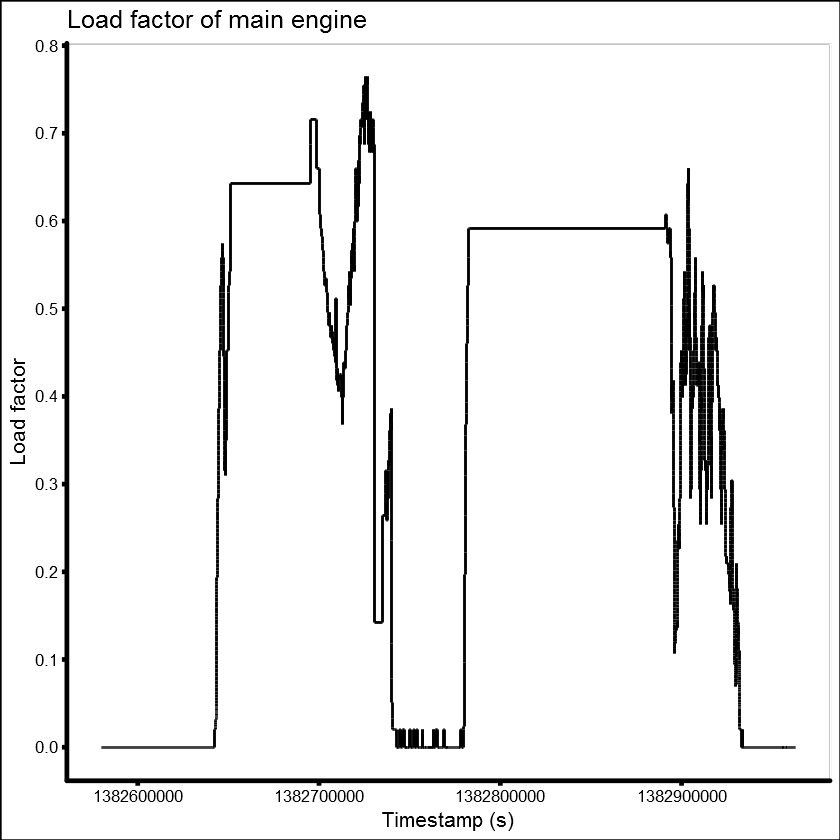

In [179]:
#duty cycle
p=ggplot()
#p=p+geom_segment(data=temp1,aes(x=time1,xend=time2,y=load.main,yend=load.main),color='red',size=2)
p=p+geom_segment(data=temp1,aes(x=time1,xend=time2,y=load.main,yend=load.main),color='black',size=0.6)
p=p+geom_segment(data=temp2,aes(x=time2,xend=time1,y=load.main1,yend=load.main2),color='black',size=0.6)
#背景色为白色
p=p+ theme_publish+
  labs(y='Load factor',x='Timestamp (s)',title='Load factor of main engine')+
  scale_y_continuous(breaks=seq(0,1,by=0.1))
p

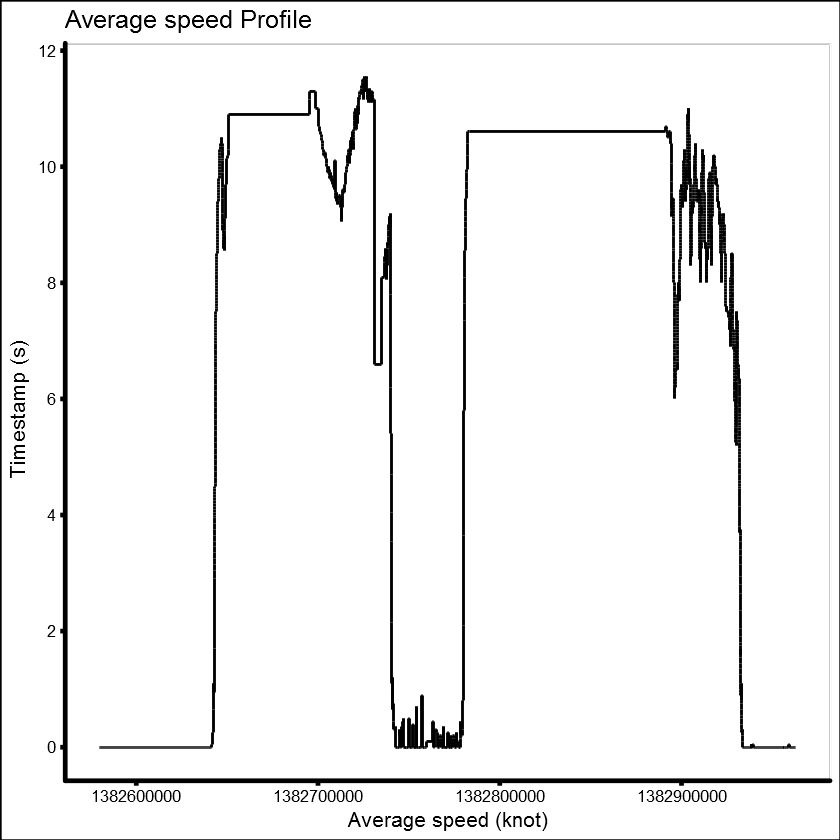

In [180]:
#-----------------avgspeed------------------------
p=ggplot()
#p=p+geom_segment(data=temp1,aes(x=time1,xend=time2,y=load.main,yend=load.main),color='red',size=2)
p=p+geom_segment(data=lines[1:(nrow(lines)-1),],aes(x=time1,xend=time2,y=avgspeed/10,yend=avgspeed/10),color='black',size=0.6)
p=p+geom_segment(data=temp2,aes(x=time2,xend=time1,y=avgspeed1/10,yend=avgspeed2/10),color='black',size=0.6)
#背景色为白色
p=p+ theme_publish+
  labs(x='Average speed (knot)',y='Timestamp (s)',title='Average speed Profile')+
  scale_y_continuous(breaks=seq(0,12,by=2))
p

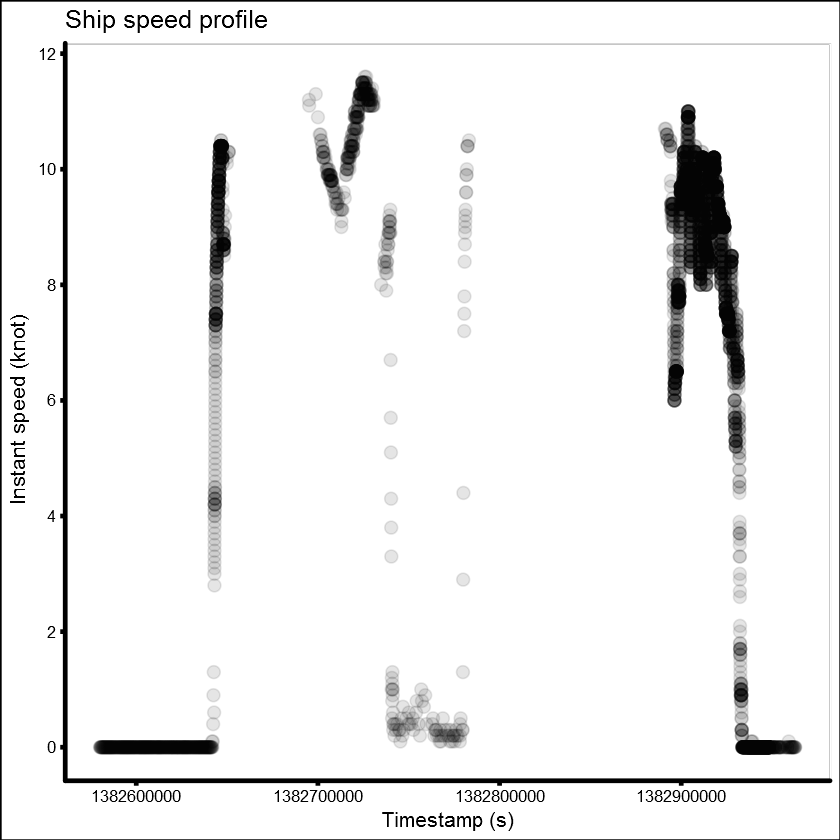

In [182]:
#----ship instantous speed-----
p=ggplot(data=points,aes(x=time,y=sog/10))+geom_point(size=3,shape=21,fill='black',alpha=0.1)
p=p+labs(x="Timestamp (s)",y="Instant speed (knot)",title="Ship speed profile")+scale_y_continuous(breaks=seq(0,12,by=2))
p=p+theme_publish
p

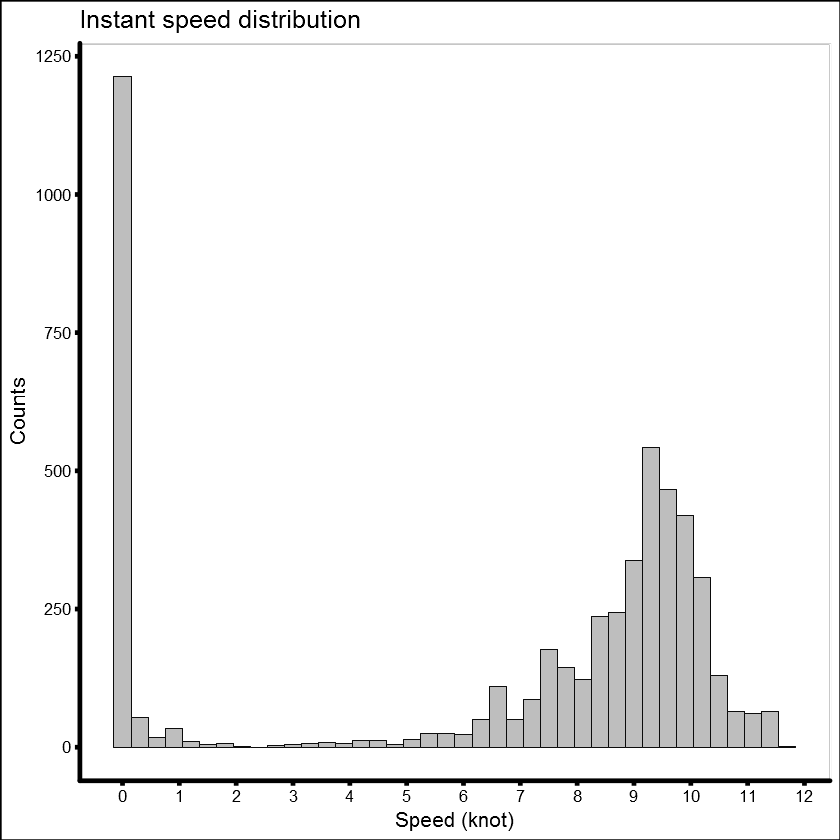

In [184]:
#-----航速频率分布------
p=ggplot(data=points,aes(x=(sog/10)))
p=p+geom_histogram(color='black',fill='grey',binwidth=0.3,size=0.2)
p=p+labs(x="Speed (knot)",y='Counts',title="Instant speed distribution")+
  scale_x_continuous(breaks=seq(0,12))
p=p+ theme_publish
p

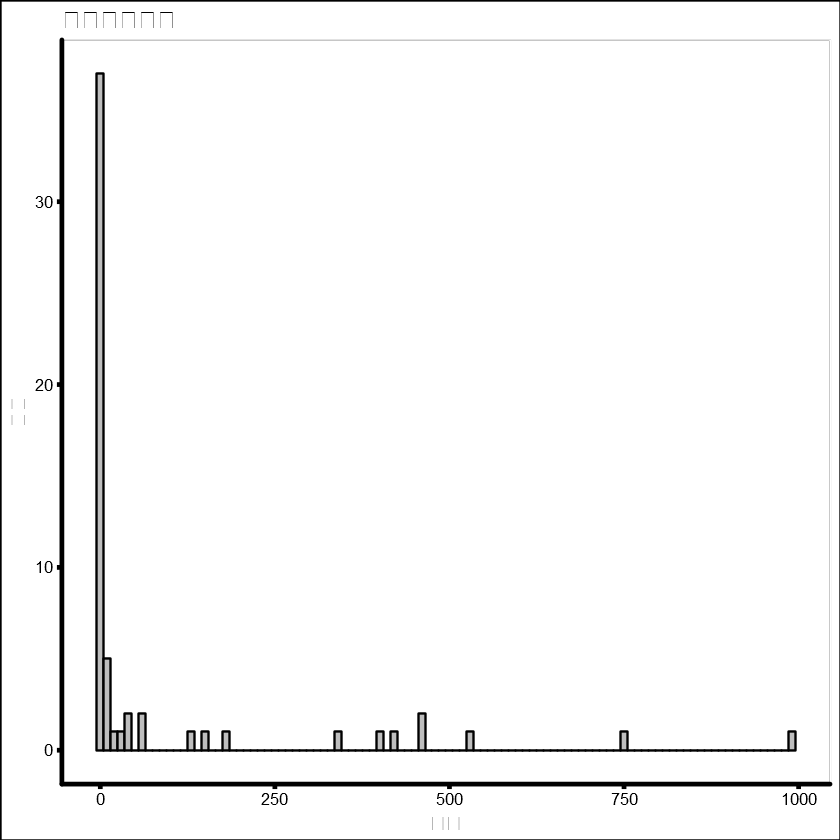

In [203]:
#------------每个网格包含的网格航段数量----------------
temp4=ge4[,list(lon=grid.x,lat=grid.y,CO2)]
p=ggplot(data=ge2[,.N,by=gid],aes(x=N))
p=p+geom_histogram(color='black',fill='grey',binwidth=10,size=0.5)
p=p+labs(x="网格",y='数量',title="网格航段分布")
p=p+ theme_publish
p

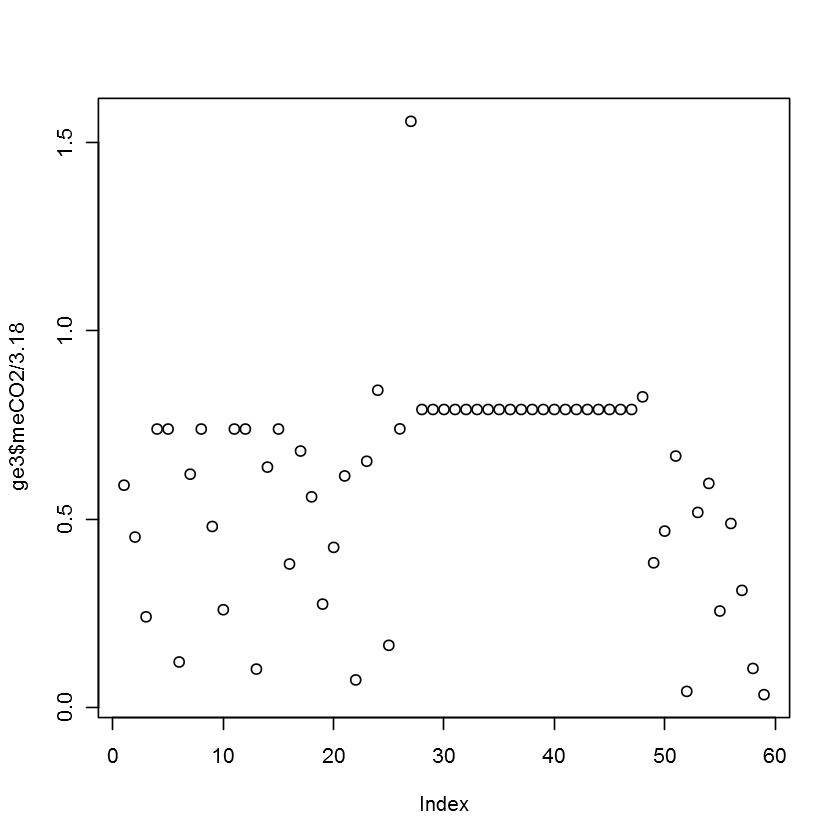

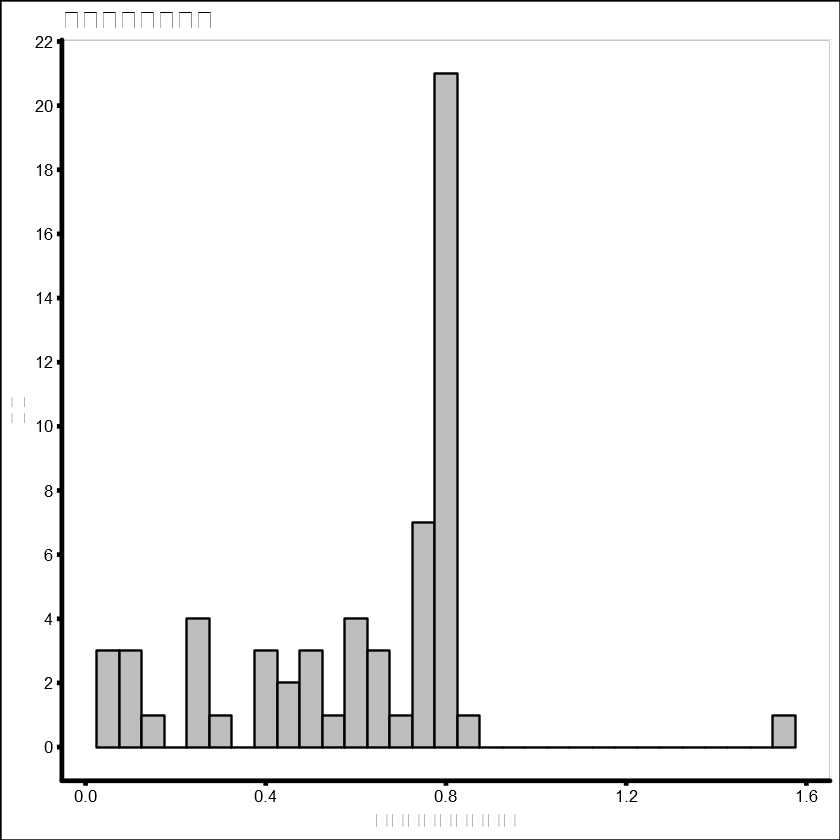

In [204]:
#--------每个网格的主机油耗量---------------
plot(ge3$meCO2/3.18)
p=ggplot(data=ge3,aes(x=meCO2/3.18))
p=p+geom_histogram(color='black',fill='grey',binwidth=0.05,size=0.5)
p=p+labs(x="主机网格油耗（吨）",y='数量',title="主机网格油耗分布")+
  scale_y_continuous(breaks=seq(0,25,by=2))+
  scale_x_continuous(breaks=seq(0,5,by=0.4))
p=p+ theme_publish
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


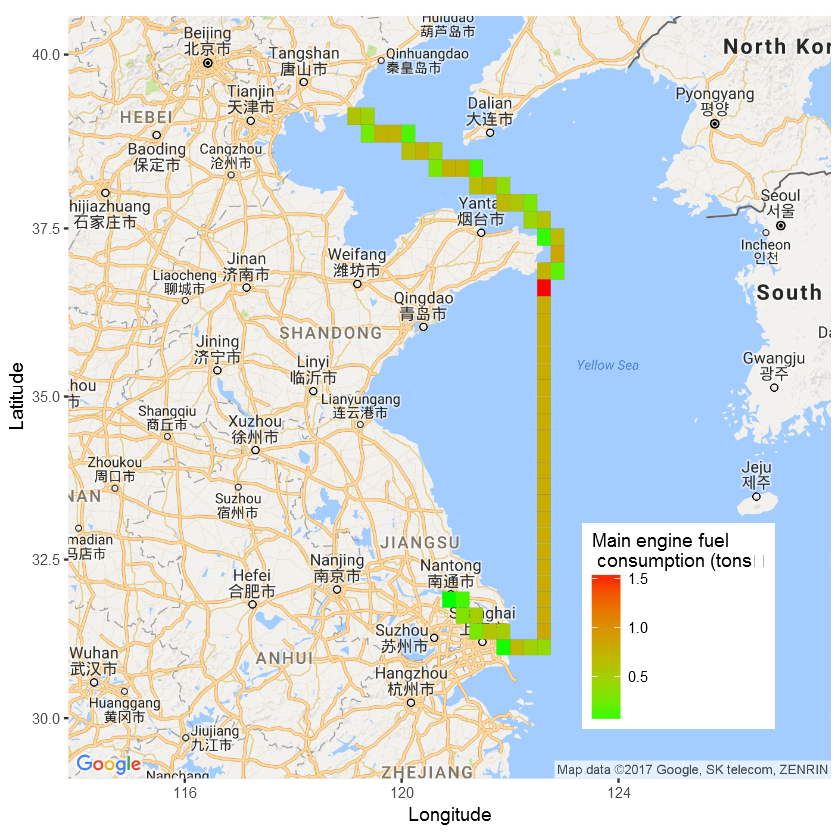

In [202]:
#--主机油耗空间分布----
#p=getMap(temp3,6)
temp3=ge3[,list(lon=grid.x,lat=grid.y,meCO2,aeCO2,boCO2,mePM2.5,aePM2.5,boPM2.5,meNOx,aeNOx,boNOx,meSOx,aeSOx,boSOx)]
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=temp3,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=meCO2/3.18),color='black',size=0.01)
p=p+scale_fill_gradient('Main engine fuel \n consumption (tons）',low='green',high='red')
p=p+labs(x="Longitude",y="Latitude")+
  theme(legend.position=c(0.8,0.2))
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


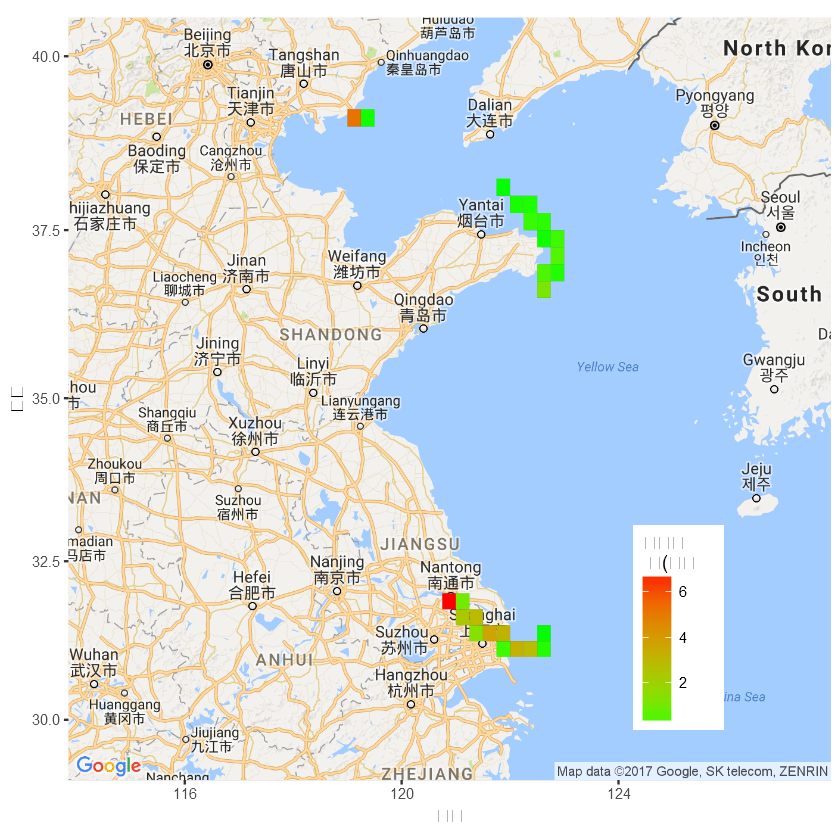

In [207]:
#--主机油耗空间分布：按照轨迹点----
totalPoints=nrow(points)
totalOil=sum(temp3$meCO2)/3.18
geTemp=points[,list(fuel=.N/totalPoints*totalOil,lon=g.lon,lat=g.lat),list(g.lon,g.lat)]

#p=getMap(temp3,6)
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=geTemp,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=fuel),color='black',size=0.01)
p=p+scale_fill_gradient('主机能 \n 耗(吨）',low='green',high='red')
p=p+labs(x="经度",y="纬度")+
  theme(legend.position=c(0.8,0.2))
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


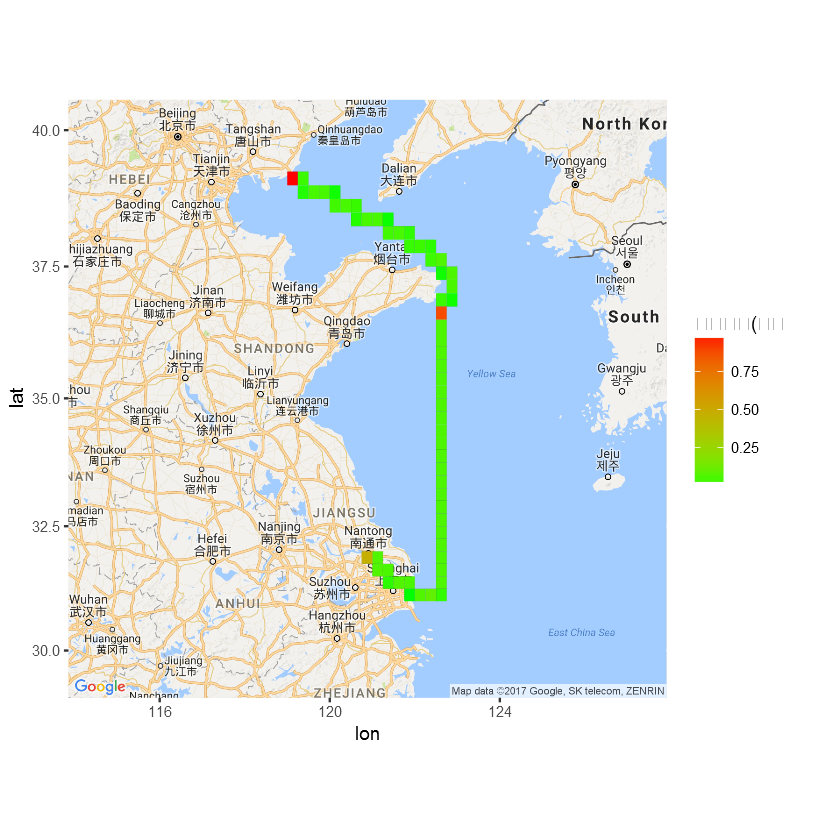

In [208]:
#p=getMap(temp3,6)
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=temp3,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=aeCO2/3.18),color='black',size=0.01)
p=p+scale_fill_gradient('辅机能耗(吨）',low='green',high='red')
# p=p+scale_colour_gradient(colours=rainbow(4))
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


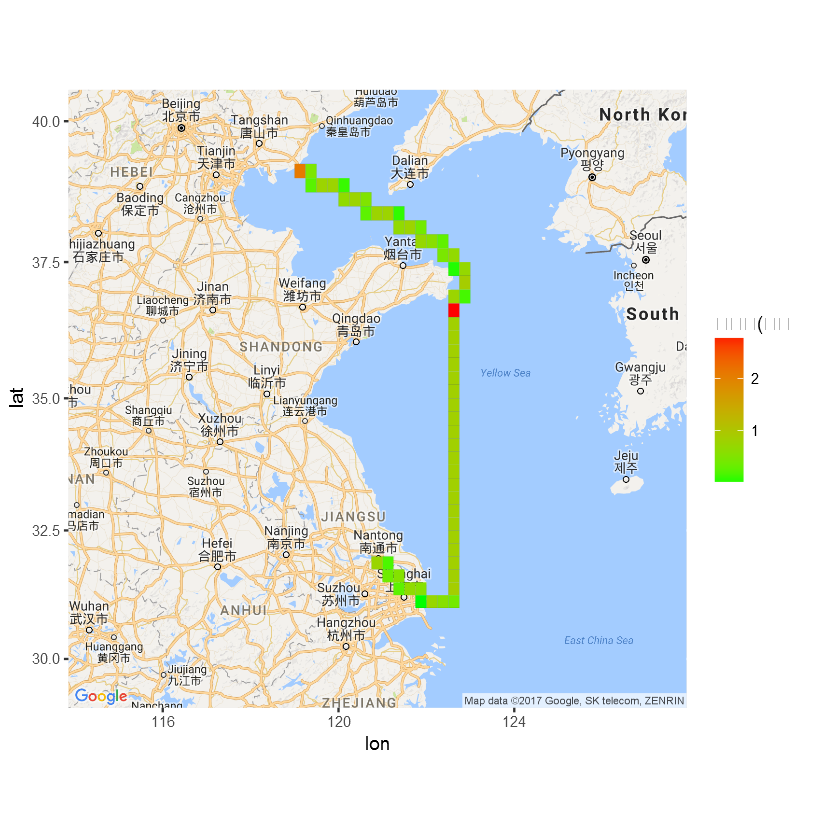

In [210]:
#p=getMap(temp3,6)
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=temp3,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=(meCO2+aeCO2+boCO2)/3.18),color='black',size=0.01)
p=p+scale_fill_gradient('总能耗(吨）',low='green',high='red')
# p=p+scale_colour_gradient(colours=rainbow(4))
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


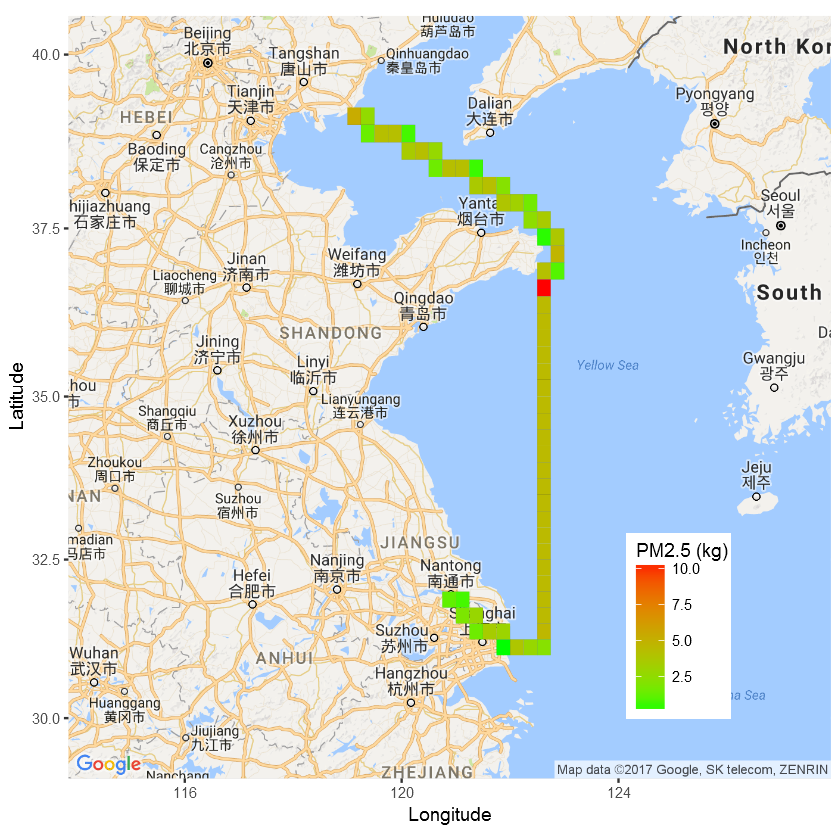

In [211]:
#pm2.5
#p=getMap(temp3,6)
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=temp3,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=1000*(mePM2.5+aePM2.5+boPM2.5)),color='black',size=0.01)
p=p+scale_fill_gradient('PM2.5 (kg)',low='green',high='red')
p=p+labs(x="Longitude",y="Latitude")+
  theme(legend.position=c(0.8,0.2))
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


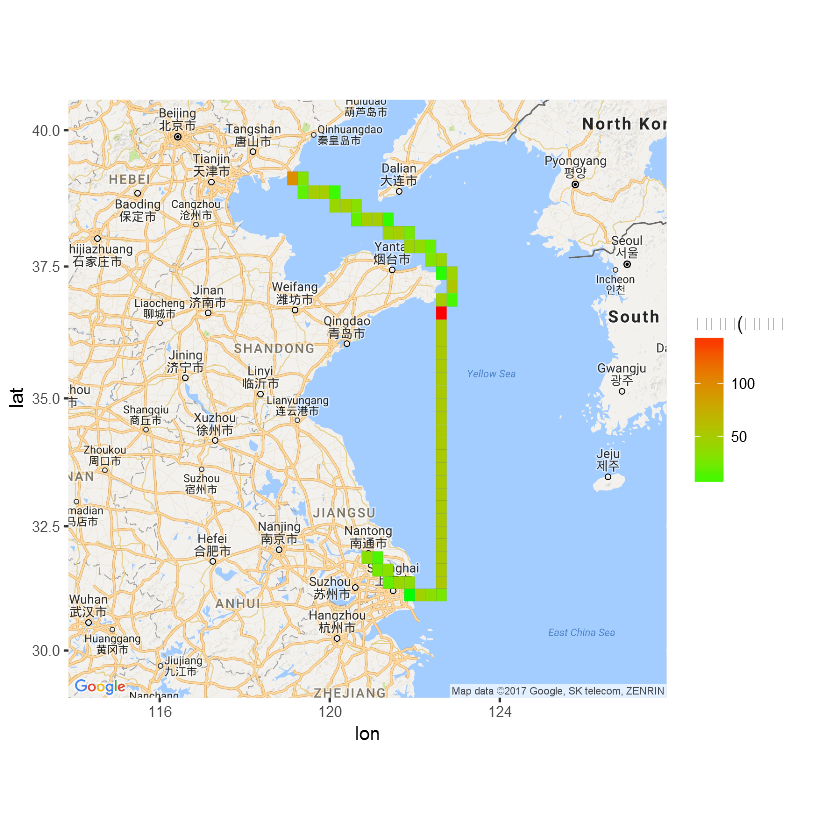

In [213]:
#NOx
#p=getMap(temp3,6)
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=temp3,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=1000*(meNOx+aeNOx+boNOx)),color='black',size=0.01)
p=p+scale_fill_gradient('氮化物(千克）',low='green',high='red')
# p=p+scale_colour_gradient(colours=rainbow(4))
p

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


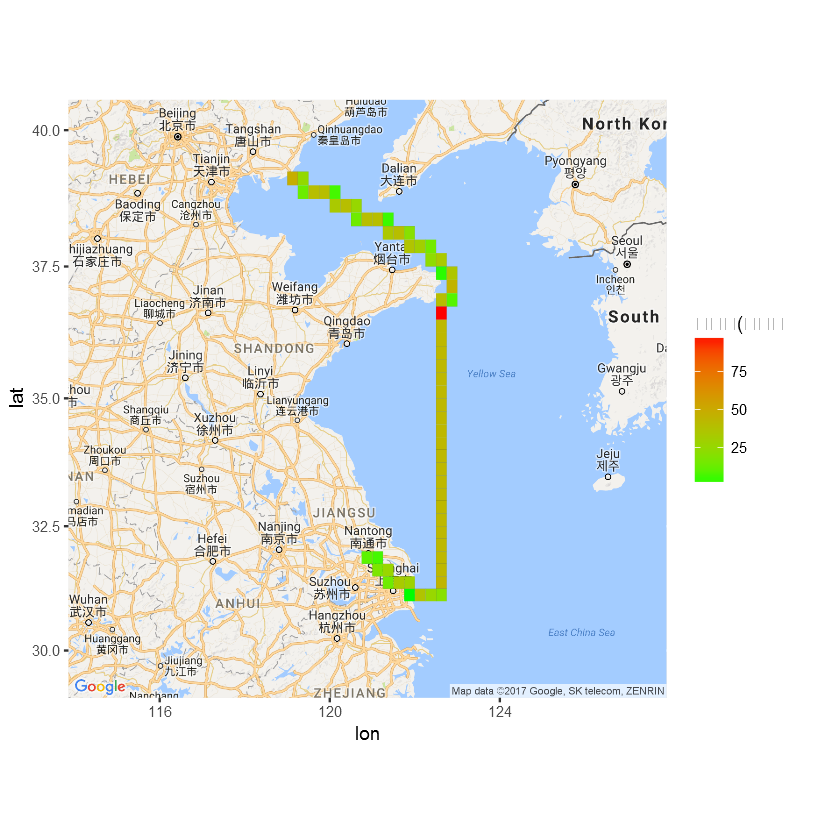

In [214]:
#SOx
#p=getMap(temp3,6)
centerX=0.5*(max(temp3$lon)+min(temp3$lon))
centerY=0.5*(max(temp3$lat)+min(temp3$lat))
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_rect(data=temp3,aes(xmin=lon,xmax=lon+0.25,ymin=lat,ymax=lat+0.25,fill=1000*(meSOx+aeSOx+boSOx)),color='black',size=0.01)
p=p+scale_fill_gradient('硫化物(千克）',low='green',high='red')
# p=p+scale_colour_gradient(colours=rainbow(4))
p


CO2      PM2.5     SOx      NOx     
1 132.2464 0.2071531 1.964908 2.450623

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=35,120.875&zoom=6&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


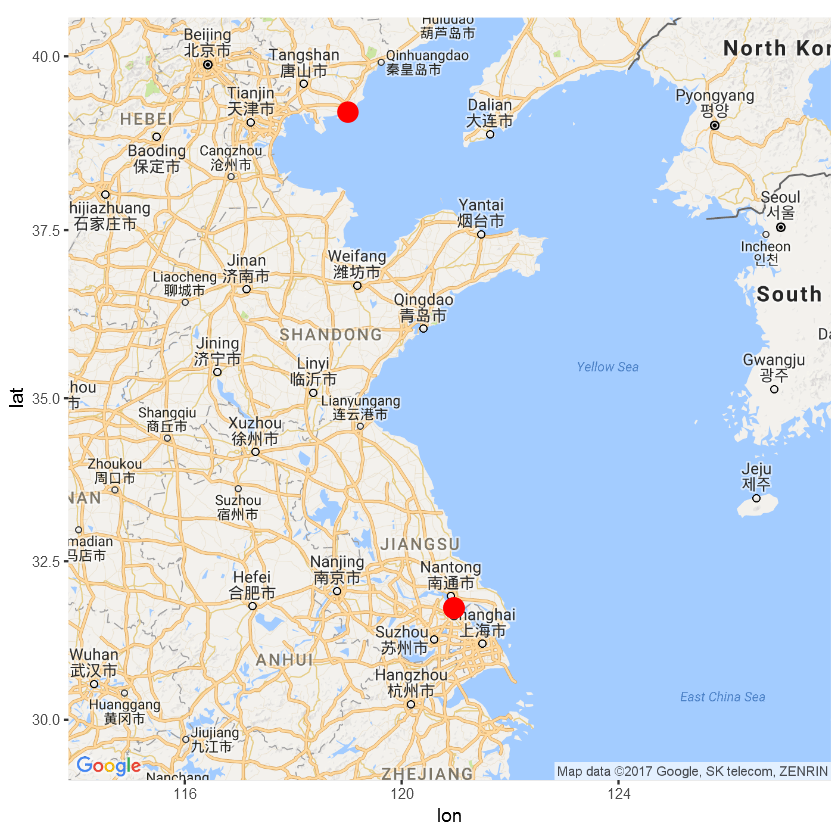

In [215]:
#港区与非港区排放量
port1=points[1,]
port2=points[nrow(points),]
temp4=ge4[,dist2port1:=distance(grid.x,grid.y,port1$lon,port1$lat)/1852]
temp4=ge4[,dist2port2:=distance(grid.x,grid.y,port2$lon,port2$lat)/1852]
temp5=temp4[dist2port1<20|dist2port2<20,]#小于20海里的网格
portAreaE=temp5[,list(portCO2=sum(CO2),portPM2.5=sum(PM2.5),portSOx=sum(SOx),portNOx=sum(NOx))]
ge4[,list(CO2=sum(CO2),PM2.5=sum(PM2.5),SOx=sum(SOx),NOx=sum(NOx))]
p<-ggmap(get_map(location=c(centerX,centerY),zoom=6,source='google',maptype = 'roadmap'))
p=p+geom_point(data=points[1,],aes(lon,lat),color='red',size=5)
p=p+geom_point(data=points[nrow(points),],aes(lon,lat),color='red',size=5)
p=p+geom_point(data=points[nrow(points),],aes(lon,lat),color='red',size=5)

# p=p+scale_colour_gradient(colours=rainbow(4))
p

In [218]:
#----calculate fuel consumption of main engine with Ng's method------
# 主机和辅机能耗都是通过航行模式再乘以在该模式的时间。
# 主要分为靠泊（<10)\机动（10,80），慢速（80-120），高速（》120）,四种模式

ps=points
ps=ps[,mode:=0]
ps=ps[sog<10,mode:=1]
ps=ps[sog<80&sog>=10,mode:=2]
ps=ps[sog<120&sog>=80,mode:=3]
ps=ps[sog>=120,mode:=4]
ps=ps[,load:=(sog/120)^3]
ps=ps[load<0.02&mode==2,load:=0.02]

ln=lines
setkey(ln,time1)
ln2=data.table(cbind(ln[,list(time1,timespan)],ps[1:5106,list(mode,load)]))

#main engineer
mmm=ln2[mode>1,list(sum(timespan)/3600*mean(load)),mode]*213/1000*4400/1000
sum(mmm$V1)
#AE c(0.120,0.403,0.242) 为 Ng中使用的参数。这里将用EPA 2009 的数据 c(0.22,0.45,0.27)
mmm2=ln2[,list(sum(timespan)/3600),mode]*217/1000*4400*0.191/1000*c(0.22,0.45,0.27)
sum(mmm2$V1)

[1] 31.84324

[1] 5.036129

Loading required package: sp
Checking rgeos availability: TRUE
rgeos version: 0.3-21, (SVN revision 540)
 GEOS runtime version: 3.5.0-CAPI-1.9.0 r4084 
 Linking to sp version: 1.2-3 
 Polygon checking: TRUE 



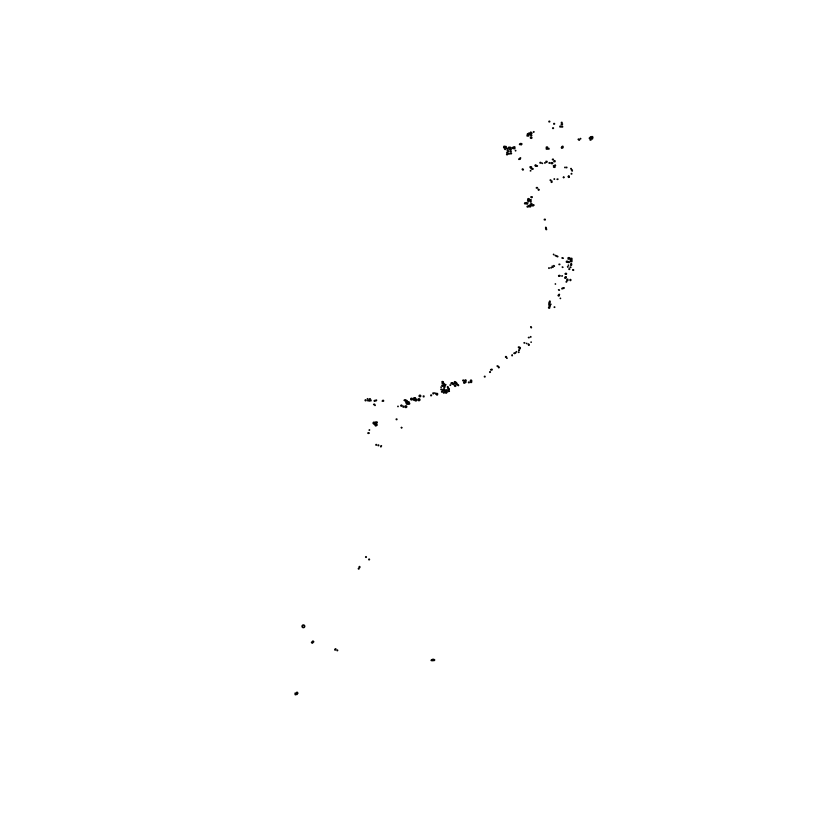

In [194]:
library(maptools)
library(rgeos)
mydat = readShapePoly("D://胡坚堃/电子海图/电子海图/锚地.shp")
plot(mydat)